In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.viridis

import numpy as np
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg
import sys
import pymc3 as pm
import pandas as pd
%config InlineBackend.figure_format = 'retina'

# Goals

In this notebook, I will take the embedding values from the previous notebook (`keras-sequence-autoencoder`) and see if I can perform GP regression on them.

# Data

The input data here are the 'embedding values' from the previous notebook. At the moment, it is very coarse-grained (by year only) and as such is very crude, but for forecasting purposes it's a relevant time scale.

In the raw dataframe, each row is one sequence, and each sequence has its two embedding coordinates (`Means 0` and `Means 1` paired with the year of isolation.

In [4]:
# Read in the data from CSV.
df = pd.read_csv('embedding_vals.csv', index_col=0)
df.head()

,years,Means 0,Means 1
0,2011,1.949354,0.598884
1,2015,0.508923,1.252961
2,2012,1.538876,1.400515
3,2015,0.126540,3.254572
4,2016,-0.437363,2.561972


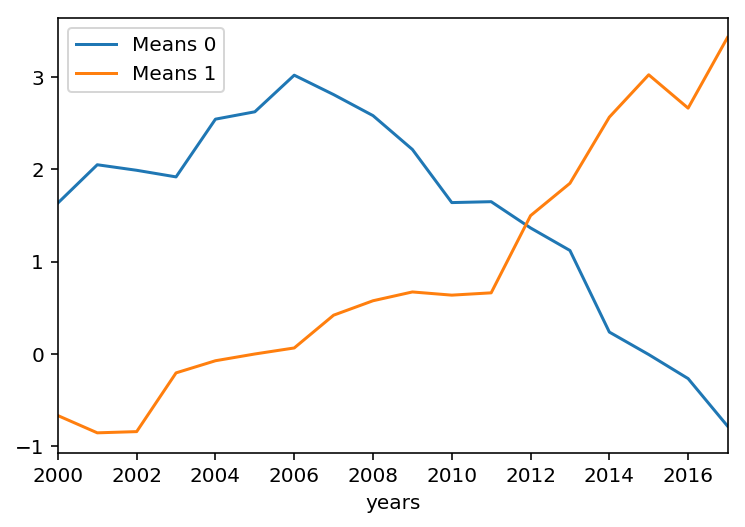

In [5]:
# Just checking: plot the mean over year. 
df.groupby('years').mean().plot()

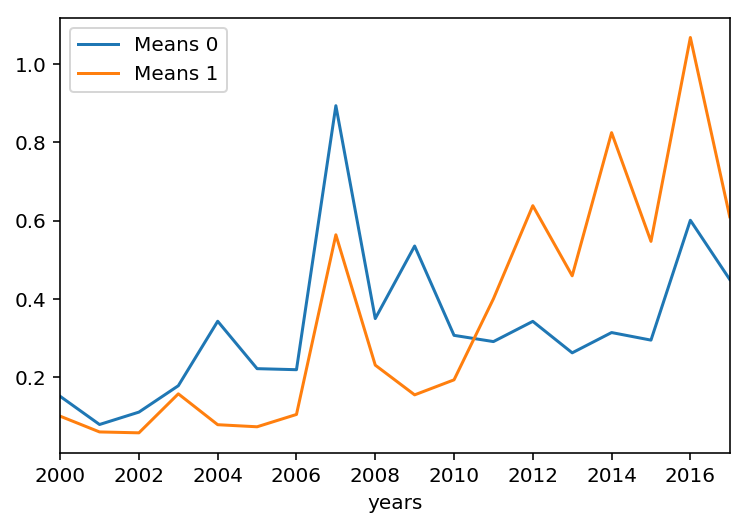

In [6]:
# Also just for sanity checking purposes; we may be able to do GP regression on the standard deviation over time. 
df.groupby('years').std().plot()

Here, I will try this thing called 'back-testing'. The core idea here is to hold out the latest data point and use the model trained on the rest of the data to predict that latest datapoint.

In [7]:
steps = 1  # We will hold out n time steps.

# Sanity check.
df.groupby('years').mean()['Means 1'].values[:-steps]

array([ -6.67016230e-01,  -8.53864137e-01,  -8.40666575e-01,
        -2.04148578e-01,  -7.27075153e-02,   5.00480695e-04,
         6.57548489e-02,   4.21047562e-01,   5.77297771e-01,
         6.72706728e-01,   6.38108455e-01,   6.63090845e-01,
         1.49939658e+00,   1.85017485e+00,   2.56664704e+00,
         3.02585806e+00,   2.66453394e+00])

In [8]:
# X = np.array(df.groupby('years').mean().index)
X = np.arange(len(df.groupby('years').mean().index[:-steps])).reshape(-1, 1)
# Y = df.groupby('years').mean()['Means 0'].values
Y = df.groupby('years').mean()['Means 1'].values[:-steps]

allX = np.arange(len(df.groupby('years').mean().index)).reshape(-1, 1)
allY = df.groupby('years').mean()['Means 1'].values


In [9]:
# Sanity check: We have 18 data points over time, so there should only be 18-steps data points going into the 
# training set.
X.shape, Y.shape


((17, 1), (17,))

In [10]:
# Model specification. We use PyMC3's GP example as the basis for this.
with pm.Model() as model:
    l = pm.Uniform('l', 0, 30)
    
    # Covariance function
    log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
    s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))
    f_cov = s2_f * pm.gp.cov.ExpQuad(input_dim=1, lengthscales=l)
    # f_cov = s2_f * pm.gp.cov.Linear(input_dim=1, c=l)
    
    # Sigma
    log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
    s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))
    
    y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=s2_n, observed={'X':X, 'Y':Y})


In [11]:
# Fit model.
with model:
    trace = pm.sample(2000)


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -16.493: 100%|██████████| 200000/200000 [01:16<00:00, 2601.63it/s]
Finished [100%]: Average ELBO = -16.495
100%|██████████| 2000/2000 [00:11<00:00, 179.42it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1eea9ac160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1ee40c07f0>]], dtype=object)

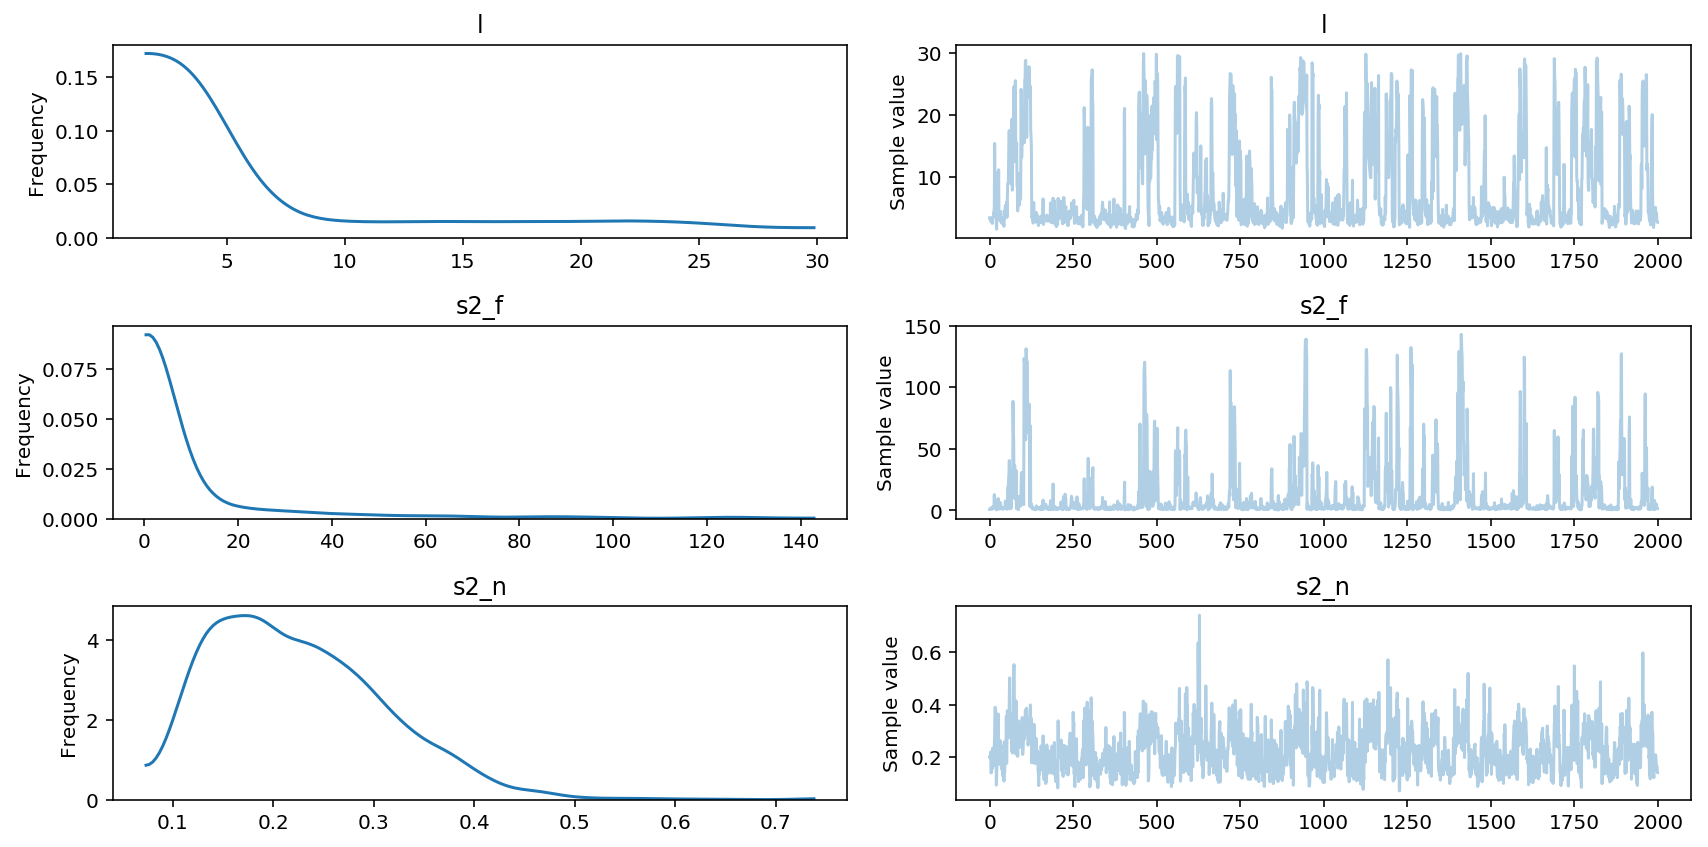

In [14]:
# Traceplot.
pm.traceplot(trace, varnames=['l', 's2_f', 's2_n'])

In [13]:
# Most important: sample from posterior.
Z = np.linspace(0, 19, 20)[:, None]
with model:
    gp_samples = pm.gp.sample_gp(trace, y_obs, Z, samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]/home/ericmjl/anaconda/lib/python3.6/site-packages/scipy/stats/_multivariate.py:533: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 1000/1000 [00:34<00:00, 28.72it/s]


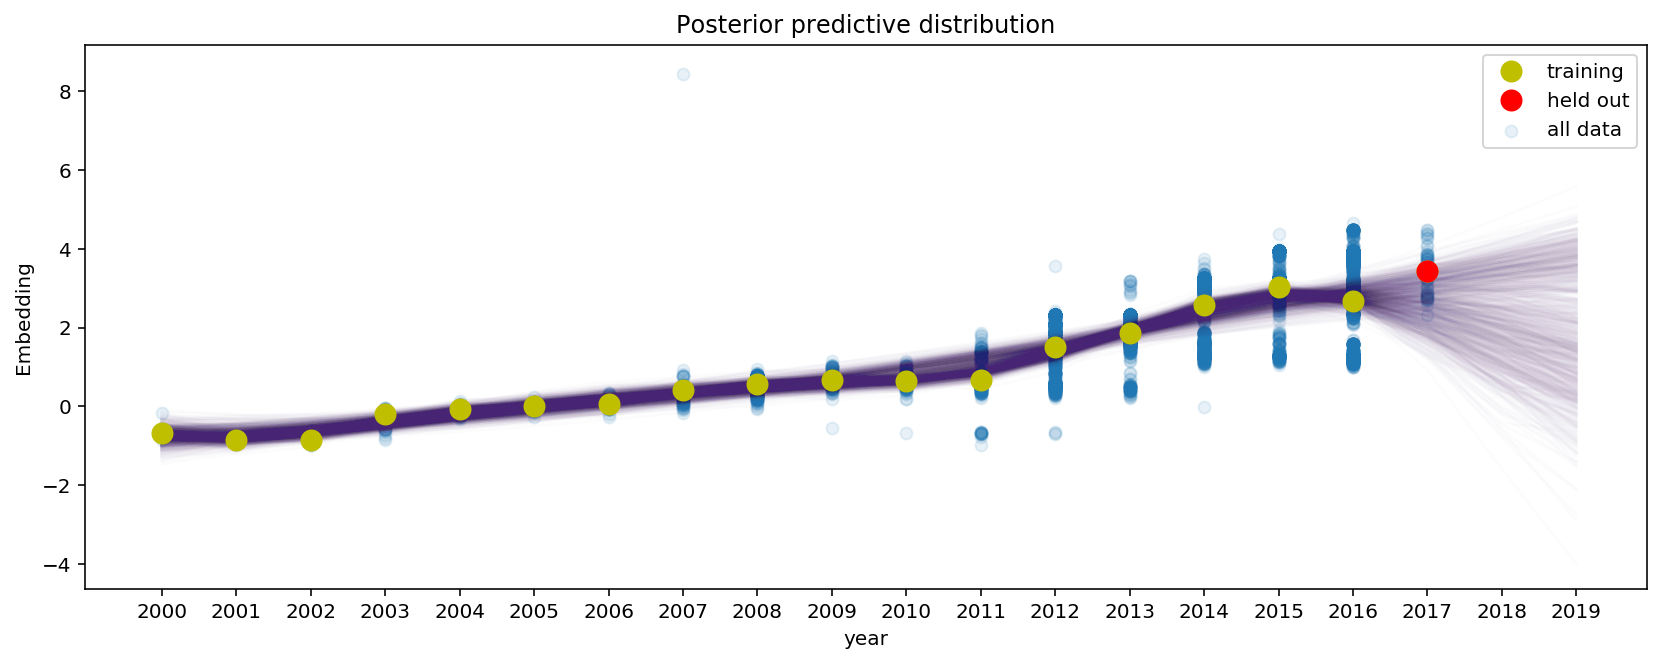

In [37]:
# Plot posterior
fig, ax = plt.subplots(figsize=(14,5))

[ax.plot(Z + min(df['years']), x, color=cm(0.1), alpha=0.01) for x in gp_samples]
# overlay the observed data
ax.plot(allX + min(df['years']), allY, 'oy', ms=10, label='training')
ax.plot(allX[-steps:] + min(df['years']), allY[-steps:], 'or', ms=10, label='held out')
ax.set_xlabel("year");
ax.set_ylabel("Embedding");
ax.set_title("Posterior predictive distribution");
ax.set_xticks(np.arange(2000, 2020))
ax.scatter(df['years'], df['Means 1'], alpha=0.1, label='all data')
ax.legend()

(Note: I have placed the final dot(s) that are left out in red.)

This is kind of cool! By putting a wide prior on the length scale parameter, we can see how the GP is simultaneously learning the longer-range and shorter-range covariances, and is hence places probability density on both the long-range and short-range trends. In particular, I'm seeing greater probability density on the longer-range trend than what I saw previously with just a short length parameter (`l=1`).

Another question I have: Is the next year's value within the 95% HPD of the posterior?

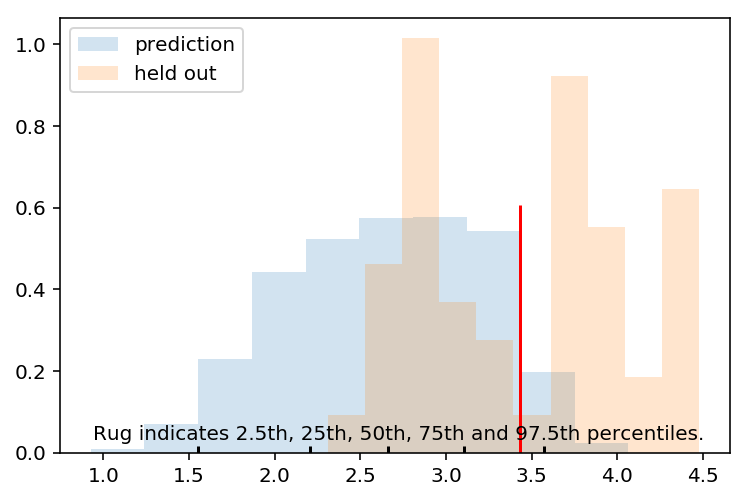

In [51]:
# Q: is the next year within the 95% HPD of posterior?
plt.hist(gp_samples[:, 18-steps], alpha=0.2, label='prediction', normed=True)  # 18 is the next timepoint 

ax = plt.gca()
ylow, yhigh = ax.get_ylim()
yrange = yhigh - ylow
plt.vlines(x=df.groupby('years').mean()['Means 1'].values[-steps], ymin=0, ymax=yhigh, color='red')
percs = np.percentile(gp_samples[:,18-steps], [2.5, 25, 50, 75, 97.5])
for p in percs:
    plt.vlines(x=p, ymin=0, ymax=yhigh * 0.025)
xlow, xhigh = ax.get_xlim()
xrange = xhigh - xlow
plt.annotate(xy=(xlow + xrange * 0.05, ylow + yrange * 0.05), 
             s='Rug indicates 2.5th, 25th, 50th, 75th and 97.5th percentiles.')
plt.hist(df[df['years'] == 2017]['Means 1'], label='held out', normed=True, alpha=0.2)
plt.legend()

Visually, about half of the data (which, btw, is bimodal) is in the 95% CI, while about half falls outside of it. There must be some bifurcation event happening.

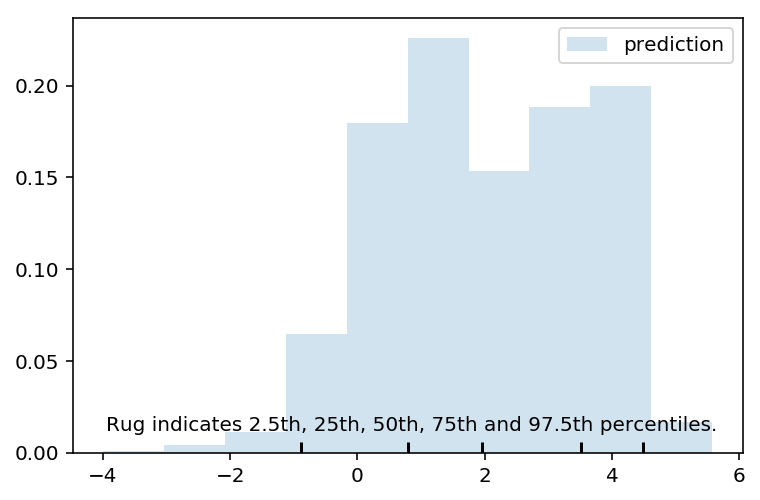

In [53]:
# Q: What does the 2019 predictions look like?

plt.hist(gp_samples[:, 19], alpha=0.2, label='prediction', normed=True)  # 18 is the next timepoint 

ax = plt.gca()
ylow, yhigh = ax.get_ylim()
yrange = yhigh - ylow
percs = np.percentile(gp_samples[:,19], [2.5, 25, 50, 75, 97.5])
for p in percs:
    plt.vlines(x=p, ymin=0, ymax=yhigh * 0.025)
xlow, xhigh = ax.get_xlim()
xrange = xhigh - xlow
plt.annotate(xy=(xlow + xrange * 0.05, ylow + yrange * 0.05), 
             s='Rug indicates 2.5th, 25th, 50th, 75th and 97.5th percentiles.')
# plt.hist(df[df['years'] == 2017]['Means 1'], label='held out', normed=True, alpha=0.2)
plt.legend()

# Next Steps

- Let's take the probability density over the two embedding dimensions, sample out 1000 new points, and sample sequences out of there.
    - This would be one step away from "antigenic prediction", where we use a scoring system to score the antigenic properties of the predicted sequence. It could well be that the new sequence doesn't have any antigenic distance from currently circulating ones, but that's a later thing to do.
- After taking out the new points, I think we can use the weblogo diagram to visualize what the distribution of polymorphisms will be over each position. That can help with identifying the highest log-likelihood sequence(s) (yes, potentially more than 1).
- The time resolution is by year; this might not be the best thing to do. Perhaps what we could do instead is go by day; after all, there are time stamps for every single sequence on the IRD.
- Predicting sequence is all nice and good, but what's biologically relevant is the antigenic profile. There's some existing metrics to use sequence space to compute antigenic distance from current vaccine strains (e.g. Ram's lab, Kannan has computed this before). Can try harnessing this to predict the antigenic profile.